# Optimize ElasicnetCV

In [1]:
import os       # using operating system dependent functionality (folders)
import sys
import glob
from functools import reduce

import pandas as pd # data analysis and manipulation
import numpy as np    # numerical computing (manipulating and performing operations on arrays of data)
import matplotlib.pyplot as plt
#import ipywidgets as widgets
from ipywidgets import interactive
import seaborn as sns

# ml stuff
from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from sklearn.svm import SVC
#from sklearn.metrics import accuracy_score
#from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import LinearRegression
from sklearn import linear_model
#from sklearn import tree
from sklearn import metrics
#from sklearn.linear_model import SGDRegressor
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
#from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNetCV
#from sklearn.ensemble import ExtraTreesRegressor
#import joblib

sys.path.insert(0, '../') # path to functions
import cvasl.seperated as sep
from cvasl.file_handler import Config
import cvasl.harmony as har

In [2]:
# First datasets for this work

EDIS_path = 'our_datasets/EDIS/'
HELIUS_path = 'our_datasets/HELIUS/'
Insight46_path = 'our_datasets/Insight46/'
SABRE_path = 'our_datasets/SABRE/'
MRI_path = 'our_datasets/StrokeMRI/'
TOP_path = 'our_datasets/TOP/'
file_name = 'TrainingDataComplete.csv'

TOP_file = os.path.join(TOP_path, file_name)
MRI_file = os.path.join(MRI_path, file_name)
EDIS_file = os.path.join(EDIS_path, file_name)
HELIUS_file = os.path.join(HELIUS_path, file_name)
Insight46_file = os.path.join(Insight46_path, file_name)
SABRE_file = os.path.join(SABRE_path, file_name)

EDIS_n = pd.read_csv(EDIS_file,index_col=0)
HELIUS_n = pd.read_csv(HELIUS_file,index_col=0)
Insight46_n = pd.read_csv(Insight46_file,index_col=0)
SABRE_n = pd.read_csv(SABRE_file,index_col=0)
TOP_n = pd.read_csv(TOP_file,index_col=0)
MRI_n = pd.read_csv(MRI_file,index_col=0)

unharm_Insight46 = Insight46_n.drop(['ID', 'Site'], axis=1)
unharm_EDIS = EDIS_n.drop(['ID', 'Site'], axis=1)
unharm_SABRE = SABRE_n.drop(['ID', 'Site'], axis=1)
unharm_StrokeMRI = MRI_n.drop(['ID', 'Site'], axis=1)
unharm_HELIUS =  HELIUS_n.drop(['ID', 'Site'], axis=1)
unharm_TOP = TOP_n.drop(['ID', 'Site'], axis=1)
unharm_TOP.head(2)

,participant_id,Age,Sex,GM_vol,WM_vol,CSF_vol,GM_ICVRatio,GMWM_ICVRatio,WMHvol_WMvol,WMH_count,ACA_B_CoV,MCA_B_CoV,PCA_B_CoV,TotalGM_B_CoV,ACA_B_CBF,MCA_B_CBF,PCA_B_CBF,TotalGM_B_CBF
0,sub-0668_1,50.40,1,0.64252,0.48470,0.26711,0.46081,0.80843,0.004496,2.944439,-1.728954,-1.560838,-1.388256,-1.419190,90.5294,80.9975,57.9326,72.1759
1,sub-0532_1,37.02,1,0.71890,0.59546,0.31236,0.44193,0.80798,0.002497,3.218876,-1.736136,-1.460070,-1.551782,-1.447404,101.2955,90.3336,67.8547,80.1958


In [3]:
sex_mapping = {1:0,2:1}
unharm_Insight46 = unharm_Insight46.assign(Sex = unharm_Insight46.Sex.map(sex_mapping))
unharm_EDIS = unharm_EDIS.assign(Sex = unharm_EDIS.Sex.map(sex_mapping))
unharm_SABRE= unharm_SABRE.assign(Sex = unharm_SABRE.Sex.map(sex_mapping))

In [4]:
unharm_TOP.columns = unharm_TOP.columns.str.lower() 
unharm_StrokeMRI.columns = unharm_StrokeMRI.columns.str.lower() 
unharm_Insight46.columns = unharm_Insight46.columns.str.lower() 
unharm_EDIS.columns = unharm_EDIS.columns.str.lower() 
unharm_SABRE.columns= unharm_SABRE.columns.str.lower() 
unharm_HELIUS.columns= unharm_HELIUS.columns.str.lower() 

In [5]:
# now the mixed model

In [6]:
unharm_TOPMRI = pd.concat([unharm_TOP, unharm_StrokeMRI])
unharm_TOPMRI.head(3)

,participant_id,age,sex,gm_vol,wm_vol,csf_vol,gm_icvratio,gmwm_icvratio,wmhvol_wmvol,wmh_count,aca_b_cov,mca_b_cov,pca_b_cov,totalgm_b_cov,aca_b_cbf,mca_b_cbf,pca_b_cbf,totalgm_b_cbf
0,sub-0668_1,50.40,1,0.64252,0.48470,0.26711,0.46081,0.80843,0.004496,2.944439,-1.728954,-1.560838,-1.388256,-1.419190,90.5294,80.9975,57.9326,72.1759
1,sub-0532_1,37.02,1,0.71890,0.59546,0.31236,0.44193,0.80798,0.002497,3.218876,-1.736136,-1.460070,-1.551782,-1.447404,101.2955,90.3336,67.8547,80.1958
2,sub-0529_1,30.57,1,0.66610,0.45798,0.28326,0.47330,0.79873,0.005131,3.044522,-1.648543,-1.567576,-1.618983,-1.520374,108.6481,99.6353,72.4565,87.2374


In [7]:
ml_matrix = unharm_TOPMRI.drop('participant_id', axis=1)
X = ml_matrix.drop('age', axis =1)
X = X.values
X = X.astype('float')
y = ml_matrix['age'].values
y=y.astype('float')


In [8]:
# now we decide to do no test train split, rather take all
X_train = X
y_train = y

In [9]:
MIXeregr = ElasticNetCV(cv=5, random_state=17)
MIXeregr.fit(X_train, y_train)


ElasticNetCV(cv=5, random_state=17)

In [10]:
sabre_ml_matrix = unharm_SABRE.drop('participant_id', axis=1)
X_sabre = sabre_ml_matrix.drop('age', axis =1)
X_sabre = X_sabre.values
X_sabre = X_sabre.astype('float')
y_sabre = sabre_ml_matrix['age'].values
y_sabre=y_sabre.astype('float')

In [11]:
X_sabre_test = X_sabre
y_sabre_test = y_sabre

In [12]:
y_sabre_pred = MIXeregr.predict(X_sabre_test)

In [13]:
data= [[
    'ElasticnetCV',
    'unharm_mri_elasticregr.sav',
    mean_absolute_error(y_sabre_test, y_sabre_pred),
    MIXeregr.score(X_sabre_test,y_sabre_test),
    metrics.explained_variance_score(y_sabre_test, y_sabre_pred)]]
eregr_results_sabre = pd.DataFrame(data, columns=['algorithm','file_name','mae', 'r2', 'explained_variance'])
eregr_results_sabre

,algorithm,file_name,mae,r2,explained_variance
0,ElasticnetCV,unharm_mri_elasticregr.sav,12.205892,-3.89704,-0.861252


In [14]:
unharm_SABRE['age'].describe()

count    705.000000
mean      71.272340
std        6.547869
min       37.000000
25%       67.000000
50%       71.000000
75%       76.000000
max       90.000000
Name: age, dtype: float64

In [15]:
frame = pd.DataFrame(y_sabre_test, y_sabre_pred)
frame = frame.reset_index()
frame = frame.rename(columns={"index": "predicted", 0:"real"})
frame = frame.sort_values(by=["real"])

In [16]:
frame

,predicted,real
373,46.934355,37.0
442,55.328149,46.0
505,49.733800,49.0
79,40.411946,53.0
441,36.554189,54.0
...,...,...
86,63.936485,88.0
633,79.569228,89.0
96,81.522001,90.0
464,80.973325,90.0


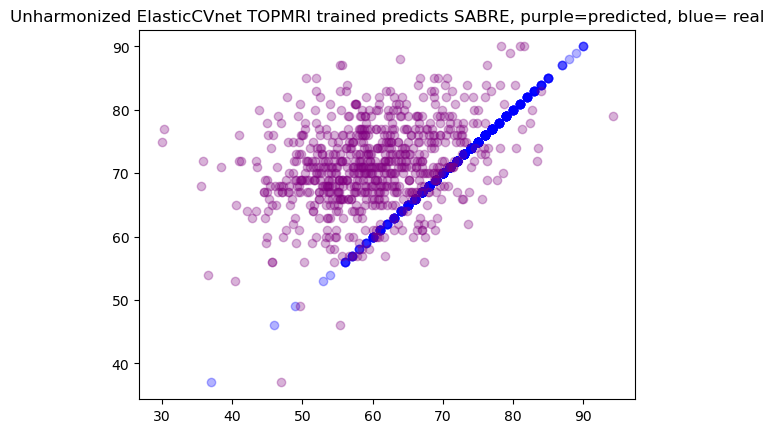

In [17]:
plt.scatter(x= frame['real'], y = frame['real'], alpha = 0.3, color ='blue')
plt.scatter(x= frame['predicted'], y = frame['real'], alpha = 0.3, color = 'purple')
plt.title('Unharmonized ElasticCVnet TOPMRI trained predicts SABRE, purple=predicted, blue= real')
plt.savefig("output-1", bbox_inches="tight",
            pad_inches=0.3, transparent=True)

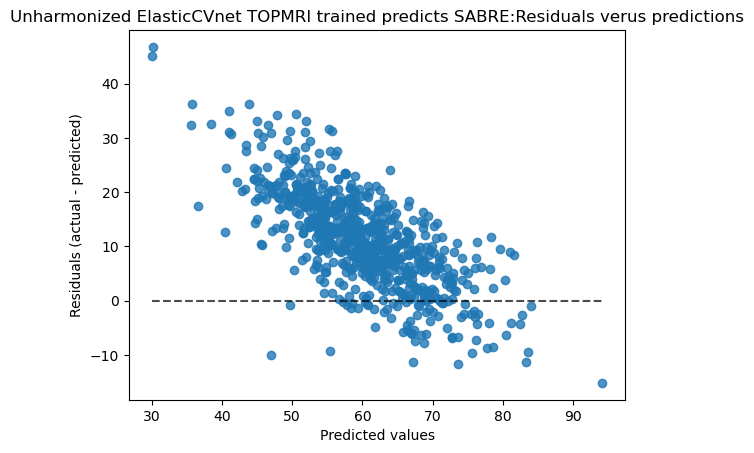

<Figure size 640x480 with 0 Axes>

In [18]:
display = PredictionErrorDisplay(y_true=y_sabre_test, y_pred=y_sabre_pred)
display.plot()
plt.title('Unharmonized ElasticCVnet TOPMRI trained predicts SABRE:Residuals verus predictions')
plt.show()
plt.savefig("output-2", bbox_inches="tight",
            pad_inches=0.3, transparent=True)

In [19]:
insight_ml_matrix = unharm_Insight46.drop('participant_id', axis=1)
X_insight = insight_ml_matrix.drop('age', axis =1)
X_insight = X_insight.values
X_insight = X_insight.astype('float')
y_insight = insight_ml_matrix['age'].values
y_insight= y_insight.astype('float')

In [20]:
X_insight_test = X_insight
y_insight_test = y_insight

In [21]:
y_insight_pred = MIXeregr.predict(X_insight_test)

In [22]:
data= [[
    'ElasticnetCV',
    'unharm_mri_elasticregr.sav',
    mean_absolute_error(y_insight_test, y_insight_pred),
    MIXeregr.score(X_insight_test,y_insight_test),
    metrics.explained_variance_score(y_insight_test, y_insight_pred)]]
eregr_results_insight = pd.DataFrame(data, columns=['algorithm','file_name','mae', 'r2', 'explained_variance'])
eregr_results_insight

,algorithm,file_name,mae,r2,explained_variance
0,ElasticnetCV,unharm_mri_elasticregr.sav,11.916573,-142.783463,-73.481235


In [23]:
data = {'real': y_insight_test, 'predicted': y_insight_pred}
y_frame_eregr_insight = pd.DataFrame(data)
y_frame_eregr_insight

,real,predicted
0,71.072222,54.480071
1,73.000000,73.254206
2,74.000000,77.334368
3,71.644444,64.622391
4,71.694444,50.798606
...,...,...
611,72.000000,61.564385
612,73.000000,78.685260
613,72.000000,47.353274
614,70.605556,56.649488


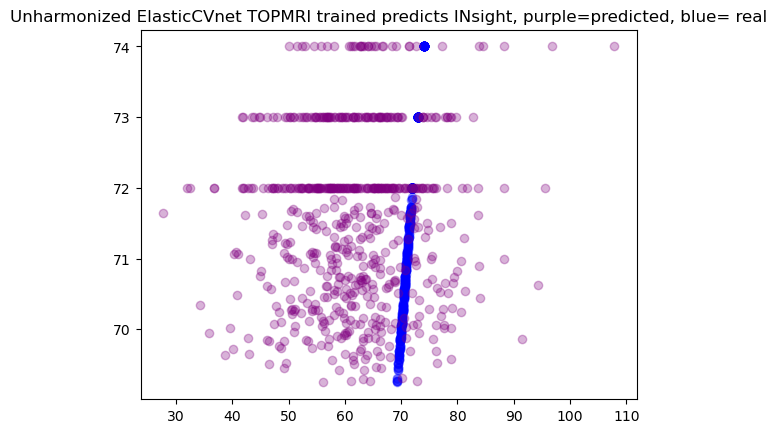

In [24]:
plt.scatter(x= y_frame_eregr_insight['real'], y = y_frame_eregr_insight['real'], alpha = 0.3, color ='blue')
plt.scatter(x= y_frame_eregr_insight['predicted'], y =y_frame_eregr_insight['real'], alpha = 0.3, color = 'purple')
plt.title('Unharmonized ElasticCVnet TOPMRI trained predicts INsight, purple=predicted, blue= real')
plt.savefig("output-3", bbox_inches="tight",
            pad_inches=0.3, transparent=True)

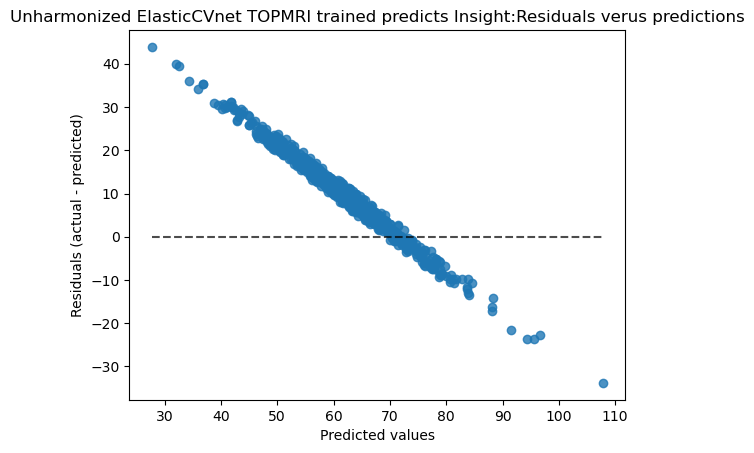

<Figure size 640x480 with 0 Axes>

In [25]:
display = PredictionErrorDisplay(y_true=y_insight_test, y_pred=y_insight_pred)
display.plot()
plt.title('Unharmonized ElasticCVnet TOPMRI trained predicts Insight:Residuals verus predictions')
plt.show()
plt.savefig("output-4", bbox_inches="tight",
            pad_inches=0.3, transparent=True)

In [26]:
edis_ml_matrix = unharm_EDIS.drop('participant_id', axis=1)
X_edis = edis_ml_matrix.drop('age', axis =1)
X_edis = X_edis.values
X_edis = X_edis.astype('float')
y_edis = edis_ml_matrix['age'].values
y_edis=y_edis.astype('float')

In [27]:
X_edis_test = X_edis
y_edis_test = y_edis

In [28]:
y_edis_pred = MIXeregr.predict(X_edis_test)

In [29]:
data = {'real': y_edis_test, 'predicted': y_edis_pred}
y_frame_eregr_edis = pd.DataFrame(data)
y_frame_eregr_edis

,real,predicted
0,66.0,31.834387
1,71.0,20.625622
2,84.0,52.274731
3,69.0,52.339224
4,69.0,65.173760
...,...,...
341,68.0,29.973920
342,62.0,24.248731
343,68.0,60.624224
344,71.0,43.578358


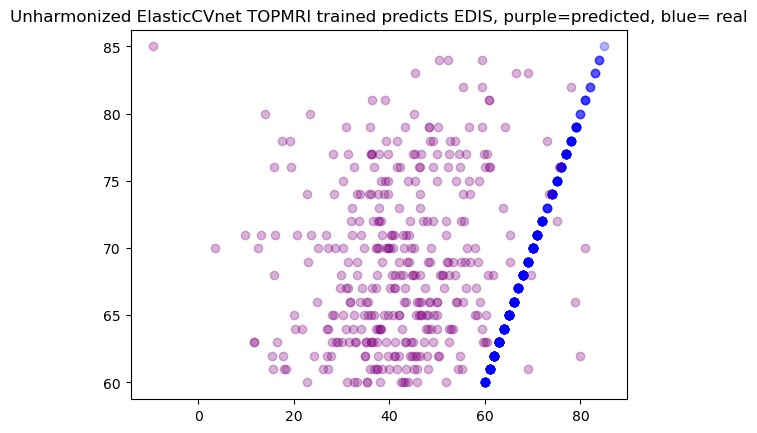

In [30]:
plt.scatter(x= y_frame_eregr_edis['real'], y = y_frame_eregr_edis['real'], alpha = 0.3, color ='blue')
plt.scatter(x= y_frame_eregr_edis['predicted'], y =y_frame_eregr_edis['real'], alpha = 0.3, color = 'purple')
plt.title('Unharmonized ElasticCVnet TOPMRI trained predicts EDIS, purple=predicted, blue= real')
plt.savefig("output-5", bbox_inches="tight",
            pad_inches=0.3, transparent=True)

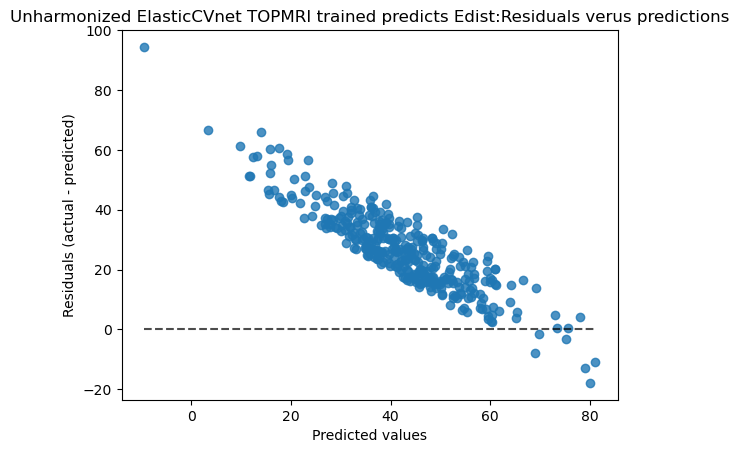

<Figure size 640x480 with 0 Axes>

In [33]:
display = PredictionErrorDisplay(y_true=y_edis_test, y_pred=y_edis_pred)
display.plot()
plt.title('Unharmonized ElasticCVnet TOPMRI trained predicts Edist:Residuals verus predictions')
plt.show()
plt.savefig("output-7", bbox_inches="tight",
            pad_inches=0.3, transparent=False)